# Fine Tuning

Fine tuning is the most common incarnation of transfer learning in the context of deep learning. It consists of taking a model that has been trained on a large dataset, such as ImageNet, and adapting its architecture and parameters to a new, smaller dataset. The key idea is that the lower layers of a convolutional network learn general features like edges and textures, while the higher layers capture more task-specific details. By freezing the lower layers and retraining only the upper layers on new data, we can achieve high performance with limited data and training time.

Effectively fine-tuning a convolutional network requires an understanding of pre-trained architectures, layer freezing, learning rate adjustments, and dataset-specific adaptations. In this tutorial, we will walk through the fine-tuning process, covering how to modify the architecture of a pre-trained model, and optimize its training strategy for a new task.

![Fine Tuning](pics/Fine-Tuning.png)

In [1]:
import torch, torchvision
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Model preparation

Before we can dwell into fine-tuning, we need to understand how to freeze layers and modify the architecture of a pre-trained model. We will illustrate these concepts by working with the [MobileNetV3](https://pytorch.org/vision/stable/models/mobilenetv3.html) architecture. As discussed in the [previous tutorial](transfer-2.ipynb), MobileNetV3 consists of three modules. 
 - `features` - A series of convolutional and pooling layers to learn a representation of the input image.
 - `avgpool` - A layer that averages the channels of the input 3D tensor to produce a feature vector.
 - `classifier` - A series of fully-connected layers that predicts the class logits from the feature vector.

Let's start by instanciating the MobileNetV3 model with randomly initialized weights.

In [2]:
architecture = mobilenet_v3_large()

### Trainable layers

We can inspect the number of trainable tensors in a model by counting the elements in the `parameters()` iterator that have `requires_grad=True`. Since we are going to need it multiple times, we define a helper function to count the number of trainable parameters in each module and submodule of a model.

In [3]:
def count_parameters(model: torch.nn.Module, trainable: bool = True):
    return sum(1 for params in model.parameters() if params.requires_grad == trainable)

def summary(model: torch.nn.Module):
    
    # Print the model name
    text = type(model).__name__
    print(text)
    print('-' * len(text))
    
    # Loop through the first level of modules
    for name, module in model.named_children():

        # Print the module name and number of parameters
        count = count_parameters(module)
        print(f"\n{name} ({type(module).__name__}): {count}")
        
        # Loop through the second level of modules
        for submodule in module.children():
            # Print the submodule name and number of parameters
            count = count_parameters(submodule)
            print(f"  - {type(submodule).__name__}: {count}")

Let's use this function to count the number of trainable parameters in the MobileNetV3 model.

In [4]:
summary(architecture)

MobileNetV3
-----------

features (Sequential): 170
  - Conv2dNormActivation: 3
  - InvertedResidual: 6
  - InvertedResidual: 9
  - InvertedResidual: 9
  - InvertedResidual: 13
  - InvertedResidual: 13
  - InvertedResidual: 13
  - InvertedResidual: 9
  - InvertedResidual: 9
  - InvertedResidual: 9
  - InvertedResidual: 9
  - InvertedResidual: 13
  - InvertedResidual: 13
  - InvertedResidual: 13
  - InvertedResidual: 13
  - InvertedResidual: 13
  - Conv2dNormActivation: 3

avgpool (AdaptiveAvgPool2d): 0

classifier (Sequential): 4
  - Linear: 2
  - Hardswish: 0
  - Dropout: 0
  - Linear: 2


### Freezing layers

To freeze a layer, we set the `requires_grad` attribute to `False` for all parameters in that layer. This prevents the optimizer from updating the weights of the layer during training. We can use the `parameters()` iterator to access the parameters of a `nn.Module` and set the `requires_grad` attribute accordingly. The code below demonstrates how to freeze the convolutional backbone of MobileNetV3.

In [5]:
for params in architecture.features.parameters():
    params.requires_grad = False

Let's count again the number of trainable parameters in each module after freezing the backbone. In this case, only the parameters in the classification head should be trainable.

In [6]:
summary(architecture)

MobileNetV3
-----------

features (Sequential): 0
  - Conv2dNormActivation: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - Conv2dNormActivation: 0

avgpool (AdaptiveAvgPool2d): 0

classifier (Sequential): 4
  - Linear: 2
  - Hardswish: 0
  - Dropout: 0
  - Linear: 2


### Modifying the architecture

Fine-tuning often requires modifying the architecture of the pre-trained model to adapt it to the new task. This can involve changing the number of output units in the classification head, adding new layers, or replacing existing layers. There are several ways to modify the architecture of a model in PyTorch. The simplest way is to just replace the layers in the classification head. For example, we can replace the two fully-connected layers of MobileNetV3 with new ones that have a different number of output units.

In [7]:
in_dim = architecture.classifier[0].in_features

architecture.classifier[0] = torch.nn.Linear(in_dim, 500)
architecture.classifier[3] = torch.nn.Linear(500, 1)  # binary classification

print(architecture.classifier)

Sequential(
  (0): Linear(in_features=960, out_features=500, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=500, out_features=1, bias=True)
)


A more drastic approach is to replace the entire classification head with a new one. This can be done by creating a new `nn.Module` for the classification head, and replacing the `classifier` attribute of the model with the new module.

In [8]:
architecture.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_dim, 500),
    torch.nn.ReLU(),
    torch.nn.Linear(500, 1)
)

print(architecture.classifier)

Sequential(
  (0): Linear(in_features=960, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=1, bias=True)
)


The most general way to modify the architecture of a pre-trained model is to subclass `nn.Module` and redefine the `forward` method. This allows us to change the architecture of the model in any way we want, including adding new layers, removing layers, or changing the connections between layers. We will use this approach to define our model for fine-tuning.

### Adapting MobileNetV3

We define a new model for fine-tuning that consists of the convolutional backbone of MobileNetV3 followed by a new classification head. This classification head contains a fully-connected layer with 500 units and ReLU activation, followed by another fully-connected layer with 1 output. We also provide methods to freeze and unfreeze the convolutional backbone of the model.

```{note}
Batch Normalization layers require special handling during fine-tuning. They should be kept in evaluation mode and never be unfrozen (to retain pre-trained statistics and parameters).
```

In [9]:
def make_trainable(model: torch.nn.Module, grad: bool):
    """Set the requires_grad attribute of all parameters in a module"""
    for params in model.parameters():
        params.requires_grad = grad

def unfreeze_layers(model: torch.nn.Sequential, count: int):
    """Unfreeze the last `count` layers of a Sequential model"""
    assert 0 <= count <= len(model)
    for layer in model[-count:]:
        make_trainable(layer, True)

def freeze_by_type(model: torch.nn.Module, layer_type: type[torch.nn.Module]|tuple[type[torch.nn.Module]]):
    """Freeze the modules of a certain type"""
    for layer in model.modules():
        if isinstance(layer, layer_type):
            make_trainable(layer, False)

def set_eval_mode(model: torch.nn.Module, layer_type: type[torch.nn.Module]):
    """Set the modules of a certain type to evaluation mode"""
    for layer in model.modules():
        if isinstance(layer, layer_type):
            layer.eval()

In [10]:
class CustomMobileNetV3(torch.nn.Module):

    def __init__(self, weights: MobileNet_V3_Large_Weights = None):
        super().__init__()
        mobilenet = mobilenet_v3_large(weights=weights)
        self.backbone = mobilenet.features
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(960*7*7, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 1)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    #----- Utility functions -----#

    def train(self, mode: bool = True):
        """Set the model to training mode, except for BatchNorm layers"""
        super().train(mode)
        set_eval_mode(self.backbone, torch.nn.BatchNorm2d)

    def freeze(self):
        """Freeze the backbone of the model"""
        make_trainable(self.backbone, False)

    def unfreeze(self, count: int):
        """Unfreeze the last layers of the backbone, except for BatchNorm layers"""
        unfreeze_layers(self.backbone, count)
        freeze_by_type(self.backbone, torch.nn.BatchNorm2d)

Let's check that the model works as expected. First, we create an instance of the model and pass a random tensor through it to check the output shape.



In [11]:
batch = torch.rand(16, 3, 224, 224)

model = CustomMobileNetV3()
output = model(batch)

print(output.shape)

torch.Size([16, 1])


Next, we freeze the convolutional backbone and check that only the parameters in the classification head are trainable.

In [12]:
model.freeze()

summary(model)

CustomMobileNetV3
-----------------

backbone (Sequential): 0
  - Conv2dNormActivation: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - Conv2dNormActivation: 0

classifier (Sequential): 4
  - Linear: 2
  - ReLU: 0
  - Linear: 2


Finally, we unfreeze some layers of the convolutional backbone and check that the corresponding parameters are trainable again (except for the BatchNorm layers).

In [13]:
model.unfreeze(3)

summary(model)

CustomMobileNetV3
-----------------

backbone (Sequential): 15
  - Conv2dNormActivation: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 0
  - InvertedResidual: 7
  - InvertedResidual: 7
  - Conv2dNormActivation: 1

classifier (Sequential): 4
  - Linear: 2
  - ReLU: 0
  - Linear: 2


## Workflow

Here is the complete workflow for fine-tuning a pre-trained model on a new task.
 - **Step 1**
    - Select a model pre-trained on a large dataset.
    - Modify the architecture of the pre-trained model for the new task.
 - **Step 2**
    - Prepare a dataset for the new task.
    - If needed, setup data augmentation on the training set.
 - **Step 3**
    - Freeze the convolutional backbone of the model.
    - Set batch normalization layers to evaluation mode.
    - Train the model on the new dataset.
 - **Step 4**
    - Unfreeze some layers of the convolutional backbone.
    - Keep batch normalization layers frozen and in evaluation mode.
    - Train the model on the new dataset again with a **very low** learning rate.

```{note}
The last step is the actual fine-tuning of the model. It is critical to only do this step after the new classification head has been trained to convergence with the convolutional backbone frozen. If we fine-tune the entire model from the beginning, the large gradient updates will destroy the pre-trained features in the convolutional backbone.
```

```{note}
It's critical to use a **very low** learning rate when fine-tuning the model. This is because we are training a much larger model than in the first round of training, on a dataset that is typically very small. As a result, we are at risk of overfitting very quickly if we apply large weight updates. Here, we only want to readapt the pretrained weights in an incremental way.
```

```{note}
During fine-tuning, Batch Normalization (BN) layers should be kept frozen and in evaluation mode to prevent them from updating their buffers and parametes. Pre-trained BN layers have learned stable statistics from a large dataset. Allowing them to update on a smaller dataset, especially with small batch sizes, can lead to inaccurate estimates and unstable training. 
```

### Step 1: Preparing the model

We download the weights of a MobileNetV3 model pre-trained on ImageNet and instanciate the custom model we defined earlier. 

In [14]:
weights = MobileNet_V3_Large_Weights.DEFAULT
model = CustomMobileNetV3(weights=weights)
preprocess = weights.transforms()

### Step 2: Preparing the data

We load the cats-vs-dogs dataset and divide it into training and test sets. We assume that the data has been downloaded and extracted to the `.data/cats-vs-dogs/PetImages` directory. The tutorial [Dataset from files](../cnn/cnn-2.ipynb) explains how to download the cats-vs-dogs dataset.

In [15]:
# TODO: Change this to the path where the dataset is stored
data_path = '.data/cats_vs_dogs/PetImages'

# Load the full dataset
dataset = torchvision.datasets.ImageFolder(data_path, transform=preprocess)

# Split the indices
train_idx, test_idx = train_test_split(range(len(dataset)), stratify=dataset.targets, test_size=0.2, shuffle=True, random_state=42)

# Create the subsets
train_ds = torch.utils.data.Subset(dataset, train_idx)
test_ds  = torch.utils.data.Subset(dataset, test_idx)

### Step 3: Training with frozen backbone

First, we import the training functions from the [previous tutorials](../cnn/cnn-0.ipynb).

In [16]:
import sys
sys.path.append('../../code')  # folder with files: train.py, eval.py, metrics.py

from train import trainer
from eval import Evaluator
from metrics import binary_accuracy

Then, we train the model with the convolutional backbone frozen and the classification head unfrozen.

**WARNING:** The code below may take a long time to run without a GPU (about 3~4 minutes per epoch).

In [17]:
def loss_fn(output, target): 
    return torch.nn.functional.binary_cross_entropy_with_logits(output.squeeze(), target.float())

model.freeze()

loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)

evaluator = Evaluator(test_ds, batch_size=128)
evaluator.add_metric("test", loss_fn)
evaluator.add_metric("accuracy", binary_accuracy)

history = trainer(model, loader, loss_fn, optimizer, epochs=5, evaluator=evaluator)

===== Training on cuda device =====


Epoch  5/5: 100%|██████████| 293/293 [01:24<00:00,  3.47it/s, accuracy=0.989, test=0.105, train_loss=0.00372]


Let's plot the loss of the model computed on the training and test sets. 

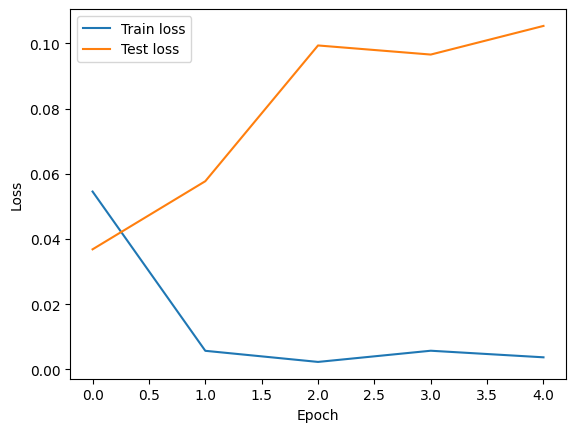

In [18]:
plt.plot(history['train'], label='Train loss')
plt.plot(history['test'], label = 'Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

We also evaluate the model on the test set and print the classification accuracy.

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')

metrics = evaluator.evaluate(model, device)

print(f"Test Accuracy: {metrics['accuracy']:.2%}")

Test Accuracy: 98.87%


### Step 4: Fine-tuning with unfrozen backbone

Finally, we unfreeze the last few layers of the convolutional backbone and train the model again with a very low learning rate.

**WARNING:** The code below may take a very long time to run.

In [20]:
model.unfreeze(3)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, amsgrad=True)

history = trainer(model, loader, loss_fn, optimizer, epochs=5, evaluator=evaluator)

===== Training on cuda device =====


Epoch  5/5: 100%|██████████| 293/293 [01:24<00:00,  3.48it/s, accuracy=0.989, test=0.106, train_loss=2.24e-6]


Let's plot the loss of the model computed on the training and test sets.

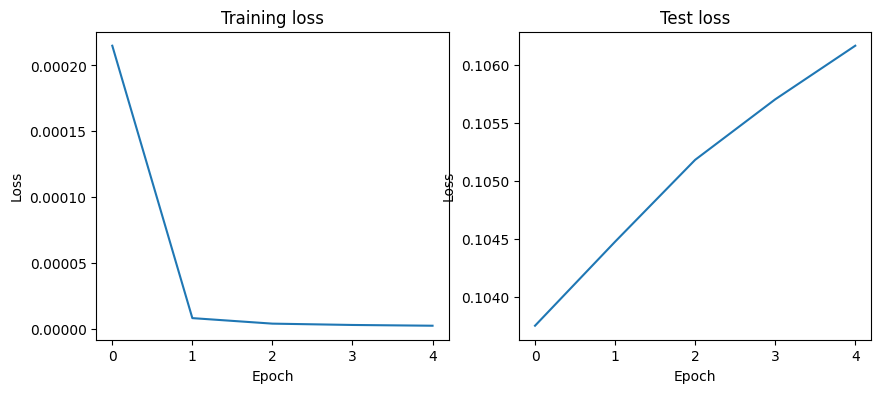

In [21]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(history['train'], label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.subplot(1,2,2)
plt.plot(history['test'], label = 'Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test loss')
plt.show()

Note that the loss curve does not show any real improvement (in fact, it is deteriorating). You may wonder, how could accuracy improve if the 
loss isn't decreasing? The answer is simple: what we display is an average of pointwise loss values, but what actually matters for accuracy 
is the distribution of the loss values, not their average, since accuracy is the result of a binary thresholding of the class probability 
predicted by the model. The model may still be improving even if this isn't reflected in the average loss.

Now, let's evaluate the fine-tuned model on the test set and print the classification accuracy.

In [22]:
metrics = evaluator.evaluate(model, device)

print(f"Test Accuracy: {metrics['accuracy']:.2%}")

Test Accuracy: 98.93%


The accuracy of the fine-tuned model did not improve significantly compared to the model with the frozen backbone. This is because the task is relatively simple, and the performance of the model with the frozen backbone is already quite high. In practice, when the dataset is small and/or the task is complex, fine-tuning can significantly improve the performance of a pre-trained model.

## Summary

In this tutorial, we learned how to fine-tune a pre-trained model on a new dataset. We started by modifying the architecture of the pre-trained model to adapt it to the new task. We then prepared the dataset for the new task and trained the model with the convolutional backbone frozen. Finally, we fine-tuned the model by unfreezing some layers of the convolutional backbone and training it again with a very low learning rate. We also discussed the importance of keeping Batch Normalization layers frozen and in evaluation mode during fine-tuning to prevent them from updating their statistics and parameters.